In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
# pip install -r requirements.txt

In [4]:
import torch
import matplotlib.pyplot as plt
from data_util import get_data_from_kaggle, restructure_date_information, get_static_df, one_label_scale_static_df, scale_stock_data
from constant import Constant
import pandas as pd
from torch import optim
from TFT import TFT_embedding, TFT, QuantilesLoss
from data import TFT_Dataset
from torch.utils.data import DataLoader ,random_split
from data_util import get_feature_length
from Fusion import CrossAttention
from Autoformer import Autoformer
from torch import nn
from Fusion import Model_Fusion

c:\Users\Luan\Documents\DL\TFT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [10]:
TFT

TFT.tft.TFT

In [11]:
constant = Constant()
constant

In [12]:
market = 'sp500' # [forbes2000, nasdaq, nyse, sp500]
year = '2017'

In [13]:
# stock = get_data_from_kaggle(market = 'sp500', start_date = f'01-01-{year}')
# generating static df can take a while because there is a rate limit with yfinance api
# static = get_static_df(stock,  constant.static_variables)

# stock.to_csv(f'dataset/sp500_{year}.csv', index=False)
# static.to_csv(f"dataset/sp500_{year}_static.csv")

In [14]:
stock = pd.read_csv(f'dataset/sp500_{year}.csv')
static = pd.read_csv(f"dataset/sp500_{year}_static.csv", index_col=0)

In [15]:
stock

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,2017-01-03,45.740002,45.930000,1739600.0,46.750000,46.490002,44.433620,A
1,2017-01-04,46.820000,46.930000,1821300.0,47.380001,47.099998,45.016628,A
2,2017-01-05,46.360001,47.049999,1503700.0,47.070000,46.540001,44.481392,A
3,2017-01-06,46.560001,46.630001,2883400.0,48.070000,47.990002,45.867260,A
4,2017-01-09,47.910000,48.009998,2575300.0,48.560001,48.139999,46.010628,A
...,...,...,...,...,...,...,...,...
605210,2022-12-06,152.089996,154.220001,1964800.0,155.500000,153.050003,153.050003,ZTS
605211,2022-12-07,149.380005,152.960007,2444100.0,153.789993,150.250000,150.250000,ZTS
605212,2022-12-08,149.199997,150.529999,2267500.0,154.350006,153.679993,153.679993,ZTS
605213,2022-12-09,152.740005,153.940002,3274900.0,156.330002,153.389999,153.389999,ZTS


In [16]:
static

,industry,sector,country,beta,marketCap,bookValue,dividendRate,dividendYield,fiveYearAvgDividendYield,debtToEquity
A,Diagnostics & Research,Healthcare,United States,1.072,39891210240,20.530,0.99,0.0074,0.66,52.787
AAL,Airlines,Industrials,United States,1.399,9680030720,-7.387,0.00,0.0000,1.27,0.000
AAP,Specialty Retail,Consumer Cyclical,United States,1.194,2744477440,42.340,1.00,0.0243,2.44,171.801
AAPL,Consumer Electronics,Technology,United States,1.240,3622499778560,3.767,1.00,0.0042,0.62,209.059
ABBV,Drug Manufacturers - General,Healthcare,United States,0.613,322113306624,3.413,6.56,0.0359,4.13,1174.815
...,...,...,...,...,...,...,...,...,...,...
XYL,Specialty Industrial Machinery,Industrials,United States,1.050,30846726144,43.593,1.44,0.0114,1.16,19.840
YUM,Restaurants,Consumer Cyclical,United States,1.095,38885851136,-27.407,2.68,0.0193,1.81,0.000
ZBH,Medical Devices,Healthcare,United States,1.021,21979760640,61.997,0.96,0.0086,0.75,53.611
ZION,Banks - Regional,Financial Services,United States,1.060,8874271744,40.251,1.72,0.0284,3.47,0.000


In [17]:
static.loc["MSFT"].values

array(['Software - Infrastructure', 'Technology', 'United States',
       np.float64(0.904), np.int64(3204173004800), np.float64(38.693),
       np.float64(3.32), np.float64(0.0078), np.float64(0.87),
       np.float64(33.657)], dtype=object)

In [18]:
valid_tickers = static.index
stock = stock[stock['Stock Name'].isin(valid_tickers)]

In [19]:
stock = stock.dropna()

In [144]:
stock_scaled_min_max, stock_scalar_min_max = scale_stock_data(stock, constant.columns_to_scale, 'min_max')
stock_scaled_standard, stock_scalar_standard = scale_stock_data(stock, constant.columns_to_scale, 'standard') 

In [21]:
stock_scaled_standard

,Date,Low,Open,Volume,High,Close,Adjusted Close,Stock Name
0,2017-01-03,-1.435333,-1.441155,-0.219570,-1.429961,-1.425749,-1.417698,A
1,2017-01-04,-1.403104,-1.411697,-0.141171,-1.411604,-1.407762,-1.400782,A
2,2017-01-05,-1.416831,-1.408162,-0.445939,-1.420637,-1.424275,-1.416312,A
3,2017-01-06,-1.410863,-1.420535,0.878017,-1.391499,-1.381520,-1.376100,A
4,2017-01-09,-1.370577,-1.379882,0.582365,-1.377222,-1.377097,-1.371940,A
...,...,...,...,...,...,...,...,...
605210,2022-12-06,0.554631,0.564748,-0.238224,0.558351,0.541016,0.576112,ZTS
605211,2022-12-07,0.498033,0.538759,0.239304,0.523447,0.483199,0.518625,ZTS
605212,2022-12-08,0.494273,0.488636,0.063357,0.534878,0.554024,0.589047,ZTS
605213,2022-12-09,0.568207,0.558973,1.067032,0.575293,0.548036,0.583093,ZTS


In [22]:
processed_df = restructure_date_information(stock_scaled_min_max)
processed_df

,Low,Open,Volume,High,Close,Adjusted Close,Stock Name,Month,Day,Day of The Week,Week of The Year
0,0.000000,0.000000,0.108231,0.000000,0.000000,0.000000,A,0,2,1,0
1,0.008217,0.007499,0.113930,0.004743,0.004594,0.004368,A,0,3,2,0
2,0.004717,0.008399,0.091776,0.002409,0.000377,0.000358,A,0,4,3,0
3,0.006239,0.005249,0.188017,0.009938,0.011296,0.010740,A,0,5,4,0
4,0.016511,0.015598,0.166526,0.013627,0.012426,0.011814,A,0,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...
605210,0.518709,0.522872,0.132240,0.522823,0.516862,0.526255,ZTS,11,5,1,48
605211,0.504664,0.516396,0.170338,0.514121,0.502468,0.511865,ZTS,11,6,2,48
605212,0.503731,0.503906,0.156301,0.516971,0.520101,0.529492,ZTS,11,7,3,48
605213,0.522077,0.521433,0.236376,0.527047,0.518610,0.528002,ZTS,11,8,4,48


In [23]:
static_df = one_label_scale_static_df(static,constant.static_variables)

In [24]:
history_cat_feature_num_list, history_cont_feature_num = get_feature_length(processed_df, constant.feature_variables)
static_cat_feature_num_list , static_cont_feature_num  = get_feature_length(static, constant.static_variables)
future_cat_feature_num_list , _                        = get_feature_length(processed_df, constant.future_feature)
_                           , prediction_con           = get_feature_length(processed_df, constant.prediction_feature)

In [25]:
history_cat_feature_num_list, history_cont_feature_num


([12, 31, 5, 53], 4)

In [26]:
history_length = 90
prediction_length = 15
hidden_size = 128
batch_size = 128
dropout = .2
num_head = 4
lr= 0.0001
momentum=0.9
num_epochs = 10
max_grad_norm = 1
split_ratio = 0.8

In [27]:
fusion_Dataset = TFT_Dataset(tft_df= processed_df , 
                        static_df=static_df,
                        autoformer_df = stock_scaled_standard,
                        constant_variable=constant, 
                        history_length= history_length, 
                        tft_prediction_length= prediction_length, 
                        autoformer_prediction_length= 7 ,
                        device = device)

In [28]:
fusion_Dataset.__len__()

562375

In [29]:
train_size = int(0.8 * fusion_Dataset.__len__())
test_size = len(fusion_Dataset) - train_size

In [30]:
train_dataset, test_dataset = random_split(fusion_Dataset, [train_size, test_size])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [32]:
count =0
for static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction,autoformer_feature_input, autoformer_prediction in train_loader:
    break
print(autoformer_prediction.size(), autoformer_prediction.device)


torch.Size([128, 7, 1]) cuda:0


In [33]:
tft_model = TFT(static_cat_feature_num_list= static_cat_feature_num_list,
            static_cont_feature_num=static_cont_feature_num,
            history_cat_feature_num_list= history_cat_feature_num_list,
            history_cont_feature_num=history_cont_feature_num,
            future_cat_feature_num_list=future_cat_feature_num_list,
            history_len = history_length,
            future_len = prediction_length,
            dropout= dropout,
            num_head = num_head,
            hidden_size = hidden_size,
            device = device)

tft_model.load_state_dict(torch.load(f'tft_model_{year}.pth', weights_only=True))
tft_model.to(device)


TFT(
  (tft_embed): TFT_embedding(
    (static_cont): Linear(in_features=7, out_features=128, bias=True)
    (static_cat): ModuleList(
      (0): Embedding(108, 128)
      (1-2): 2 x Embedding(12, 128)
    )
    (history_cont): Linear(in_features=4, out_features=128, bias=True)
    (history_cat): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
    (future_feature): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(53, 128)
    )
  )
  (cs): VariationSelection(
    (group_GRN): GRN(
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (GLU): GLU(
        (linear4): Linear(in_features=128, out_features=512, bias=True)
        (linear5): Linear(in_features=128, out_features=512, bias=True)
      )
      (droput): Dropout(p=0.0, inplace=Fal

In [34]:
autoformer_model = Autoformer(**constant.autoformer_model_config)
autoformer_model.load_state_dict(torch.load('best_long.pth'))
autoformer_model.to(device)

C:\Users\Luan\AppData\Local\Temp\ipykernel_23044\201841490.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoformer_model.load_state_dict(torch.load('best_long.pth'))


Autoformer(
  (input_projection): Linear(in_features=5, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (decomposition): DecompositionLayer(
    (moving_avg): AvgPool1d(kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.01, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiheadAttention(
   

In [33]:
fusion = Model_Fusion(tft_model=tft_model , 
             autoformer_model = autoformer_model,
             n_head= 1,
             hidden_size=hidden_size,
             device=device)
fusion.to(device)

Model_Fusion(
  (tft_model): TFT(
    (tft_embed): TFT_embedding(
      (static_cont): Linear(in_features=7, out_features=128, bias=True)
      (static_cat): ModuleList(
        (0): Embedding(108, 128)
        (1-2): 2 x Embedding(12, 128)
      )
      (history_cont): Linear(in_features=4, out_features=128, bias=True)
      (history_cat): ModuleList(
        (0): Embedding(12, 128)
        (1): Embedding(31, 128)
        (2): Embedding(5, 128)
        (3): Embedding(53, 128)
      )
      (future_feature): ModuleList(
        (0): Embedding(12, 128)
        (1): Embedding(31, 128)
        (2): Embedding(5, 128)
        (3): Embedding(53, 128)
      )
    )
    (cs): VariationSelection(
      (group_GRN): GRN(
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (GLU): GLU(
          (linear4): Linear(in_features=128, out_features=512, bias=True)
          (linear5): Linear(in_features=1

In [317]:
loss_function = QuantilesLoss( device=device)
loss_function.to(device)
optimizer = optim.Adam(fusion.parameters(), lr = lr)

In [110]:
fusion.train()
batch_loss = [] 
for epoch in range(num_epochs):
    for i,(static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, tft_prediction, autoformer_feature_input, autoformer_prediction) in enumerate(train_loader):
        output = fusion( static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, tft_prediction, autoformer_feature_input, autoformer_prediction)
        optimizer.zero_grad()
        losses = loss_function(predicted = output, targets = tft_prediction)
        loss = losses.sum()
        loss.backward()

        optimizer.step()

        if i % 1000 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i},  Loss: {loss.item()}')
        batch_loss.append(loss.item())
    print("###########################")
    print(f'Epoch: {epoch+1},  Loss: {loss.item()}')
        

Epoch: 1, Batch: 0,  Loss: 0.5517359972000122
Epoch: 1, Batch: 1000,  Loss: 0.03219452127814293
Epoch: 1, Batch: 2000,  Loss: 0.025751158595085144
Epoch: 1, Batch: 3000,  Loss: 0.025091728195548058
###########################
Epoch: 1,  Loss: 0.03178217634558678
Epoch: 2, Batch: 0,  Loss: 0.02982131764292717
Epoch: 2, Batch: 1000,  Loss: 0.0267740860581398
Epoch: 2, Batch: 2000,  Loss: 0.021991848945617676
Epoch: 2, Batch: 3000,  Loss: 0.02645004540681839
###########################
Epoch: 2,  Loss: 0.021673955023288727
Epoch: 3, Batch: 0,  Loss: 0.023682726547122
Epoch: 3, Batch: 1000,  Loss: 0.02163458801805973
Epoch: 3, Batch: 2000,  Loss: 0.021390549838542938
Epoch: 3, Batch: 3000,  Loss: 0.022306276485323906
###########################
Epoch: 3,  Loss: 0.019116155803203583
Epoch: 4, Batch: 0,  Loss: 0.022741403430700302
Epoch: 4, Batch: 1000,  Loss: 0.018931131809949875
Epoch: 4, Batch: 2000,  Loss: 0.0212588831782341
Epoch: 4, Batch: 3000,  Loss: 0.018070384860038757
############

In [99]:
output.size()

torch.Size([128, 15, 128])

In [ ]:
# torch.save(fusion.state_dict(), f"fusion_model_{year}.pth")

In [35]:
fusion = Model_Fusion(tft_model=tft_model , 
             autoformer_model = autoformer_model,
             n_head= 1,
             hidden_size=hidden_size,
             device=device)
fusion.load_state_dict(torch.load(f"fusion_model_{year}.pth", weights_only=True))
fusion.to(device)

Model_Fusion(
  (tft_model): TFT(
    (tft_embed): TFT_embedding(
      (static_cont): Linear(in_features=7, out_features=128, bias=True)
      (static_cat): ModuleList(
        (0): Embedding(108, 128)
        (1-2): 2 x Embedding(12, 128)
      )
      (history_cont): Linear(in_features=4, out_features=128, bias=True)
      (history_cat): ModuleList(
        (0): Embedding(12, 128)
        (1): Embedding(31, 128)
        (2): Embedding(5, 128)
        (3): Embedding(53, 128)
      )
      (future_feature): ModuleList(
        (0): Embedding(12, 128)
        (1): Embedding(31, 128)
        (2): Embedding(5, 128)
        (3): Embedding(53, 128)
      )
    )
    (cs): VariationSelection(
      (group_GRN): GRN(
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (GLU): GLU(
          (linear4): Linear(in_features=128, out_features=512, bias=True)
          (linear5): Linear(in_features=1

In [167]:
fusion.eval()
count = 0
err = 0
with torch.no_grad():
    for i,(static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, tft_prediction, autoformer_feature_input, autoformer_prediction) in enumerate(test_loader):
        output = fusion( static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, tft_prediction, autoformer_feature_input, autoformer_prediction)

        diff = (tft_prediction.squeeze(-1) - output[:,:,1])**2
        err += diff.sum()
        count += diff.size(0)

In [168]:
print("MSE of Fusion Model on Test Data: ", (err/count).item())

MSE of Fusion Model on Test Data:  0.01152523048222065


In [38]:
import yfinance as yf

In [39]:
AMD = yf.Ticker("MSFT")
AMD = AMD.history(interval="1d", period = "1y", auto_adjust=False, actions=False)
AMD.rename(columns={'Adj Close': 'Adjusted Close'}, inplace=True)
AMD["Stock Name"] = "MSFT"
AMD = AMD.reset_index()
AMD['Date'] = pd.to_datetime(AMD['Date'])
AMD

,Date,Open,High,Low,Close,Adjusted Close,Volume,Stock Name
0,2023-12-11 00:00:00-05:00,368.480011,371.600006,366.100006,371.299988,368.544037,27708800,MSFT
1,2023-12-12 00:00:00-05:00,370.850006,374.420013,370.459991,374.380005,371.601196,24838300,MSFT
2,2023-12-13 00:00:00-05:00,376.019989,377.640015,370.769989,374.369995,371.591278,30955500,MSFT
3,2023-12-14 00:00:00-05:00,373.309998,373.760010,364.130005,365.929993,363.213959,43277500,MSFT
4,2023-12-15 00:00:00-05:00,366.850006,372.399994,366.279999,370.730011,367.978302,78478200,MSFT
...,...,...,...,...,...,...,...,...
248,2024-12-05 00:00:00-05:00,437.920013,444.660004,436.170013,442.619995,442.619995,21697800,MSFT
249,2024-12-06 00:00:00-05:00,442.299988,446.100006,441.769989,443.570007,443.570007,18821000,MSFT
250,2024-12-09 00:00:00-05:00,442.600006,448.329987,440.500000,446.019989,446.019989,19144400,MSFT
251,2024-12-10 00:00:00-05:00,444.390015,449.619995,441.600006,443.329987,443.329987,18453100,MSFT


In [40]:
AMD_min_max, stock_scalar_min = scale_stock_data(AMD, constant.columns_to_scale, 'min_max')
AMD_scaled_standard, stock_scalar = scale_stock_data(AMD, constant.columns_to_scale, 'standard') 


In [41]:
AMD_df = restructure_date_information(AMD_min_max)
AMD_df

,Open,High,Low,Close,Adjusted Close,Volume,Stock Name,Month,Day,Day of The Week,Week of The Year
0,0.016276,0.000000,0.019635,0.052839,0.051964,0.284105,MSFT,11,10,0,49
1,0.039940,0.029147,0.063092,0.083145,0.081769,0.243629,MSFT,11,11,1,49
2,0.091562,0.062429,0.066181,0.083046,0.081672,0.329887,MSFT,11,12,2,49
3,0.064503,0.022326,0.000000,0.000000,0.000000,0.503638,MSFT,11,13,3,49
4,0.000000,0.008269,0.021429,0.047230,0.046449,1.000000,MSFT,11,14,4,49
...,...,...,...,...,...,...,...,...,...,...,...
248,0.709636,0.755142,0.718031,0.754600,0.774146,0.199345,MSFT,11,4,3,48
249,0.753370,0.770026,0.773846,0.763948,0.783407,0.158779,MSFT,11,5,4,48
250,0.756365,0.793075,0.761188,0.788055,0.807293,0.163340,MSFT,11,8,0,49
251,0.774239,0.806408,0.772152,0.761586,0.781067,0.153592,MSFT,11,9,1,49


In [169]:
AMD_Dataset = TFT_Dataset(tft_df= AMD_df , 
                        static_df=static_df,
                        autoformer_df = AMD_scaled_standard,
                        constant_variable=constant, 
                        history_length= history_length, 
                        tft_prediction_length= prediction_length, 
                        autoformer_prediction_length= 7 ,
                        device = device)

In [170]:
len(AMD_Dataset)

148

In [171]:
AMD_loader = DataLoader(AMD_Dataset , batch_size=32,shuffle=False)

In [179]:
fusion.eval()
count = 0
fusion_err = 0
tft_err = 0 
autoformer_err = 0
history_list = []
target_list = []
fusion_list = []
tft_list = []
autoformer_hist = []
autoformer_list = []
autoformer_future = []
with torch.no_grad():
    for i,(static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, target, autoformer_feature_input, autoformer_target) in enumerate(AMD_loader):
        
        output = fusion(static_cont_input, static_cat_input,history_cont_input, history_cat_input,future_input, target, autoformer_feature_input, autoformer_target)
        tft_output = tft_model(static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input)
        autoformer_output = autoformer_model(autoformer_feature_input, autoformer_target)
        
        history_list.append(history_cont_input)
        target_list.append(target)
        fusion_list.append(output)
        tft_list.append(tft_output)
        autoformer_list.append(autoformer_output)
        autoformer_hist.append(autoformer_feature_input)
        autoformer_future.append(autoformer_target)

        fusion_diff = (target.squeeze(-1) - output[:,:,1])**2
        fusion_err += fusion_diff.sum()

        tft_diff = (target.squeeze(-1) - tft_output[:,:,1])**2
        tft_err += tft_diff.sum()
        
        auto_diff = (autoformer_target.squeeze(-1) - autoformer_output)**2
        autoformer_err += auto_diff.sum()

        count += diff.size(0)

In [180]:
autoformer_feature_input[0].size()

torch.Size([90, 5])

In [181]:
history_list[0][0][:,-1].size()

torch.Size([90])

In [182]:
print('MSE of Fusion on Novel Data:' , (fusion_err/count).item())
print('MSE of TFT on Novel Data:' , (tft_err/count).item())
print('MSE of Autoformer on Novel Data:' , (autoformer_err/count).item())

MSE of Fusion on Novel Data: 0.05927792564034462
MSE of TFT on Novel Data: 0.21426299214363098
MSE of Autoformer on Novel Data: 17.186622619628906


In [183]:
history = history_list[2][0][:,0].cpu().numpy()

In [159]:
predicted = prediction_list[2][0].cpu().numpy()

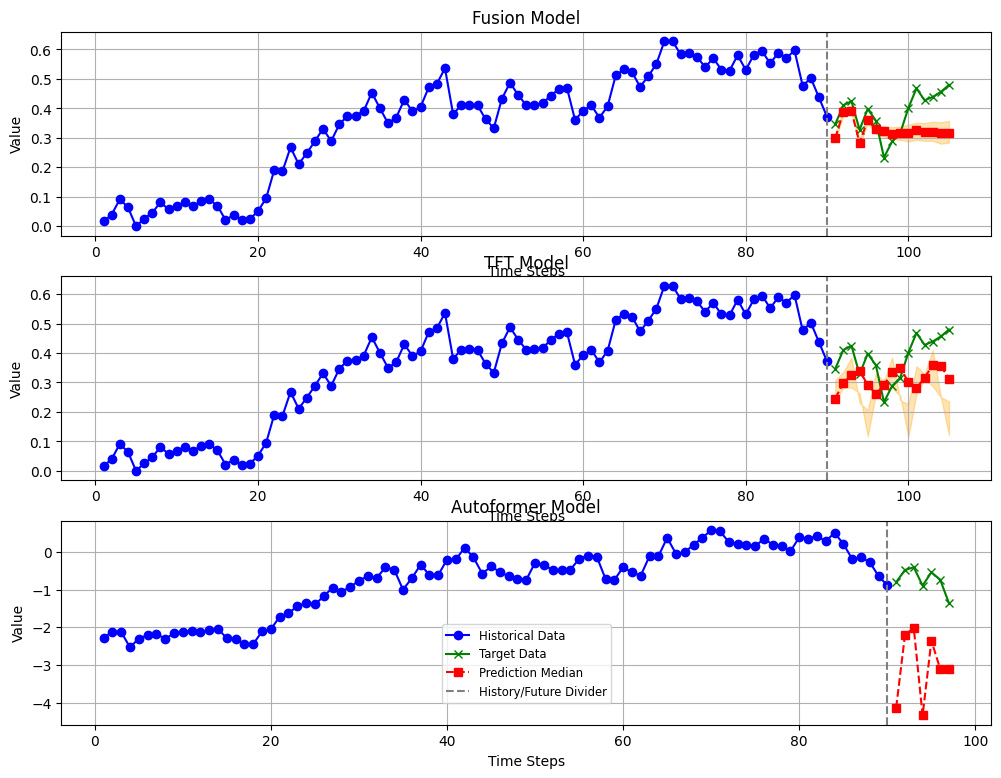

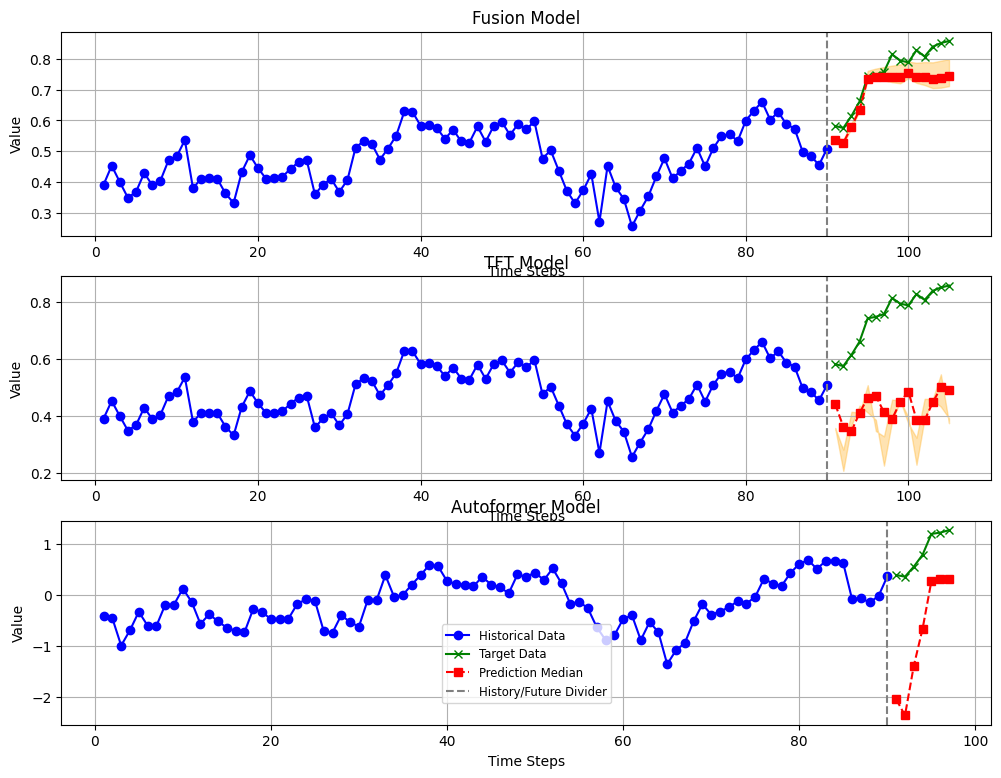

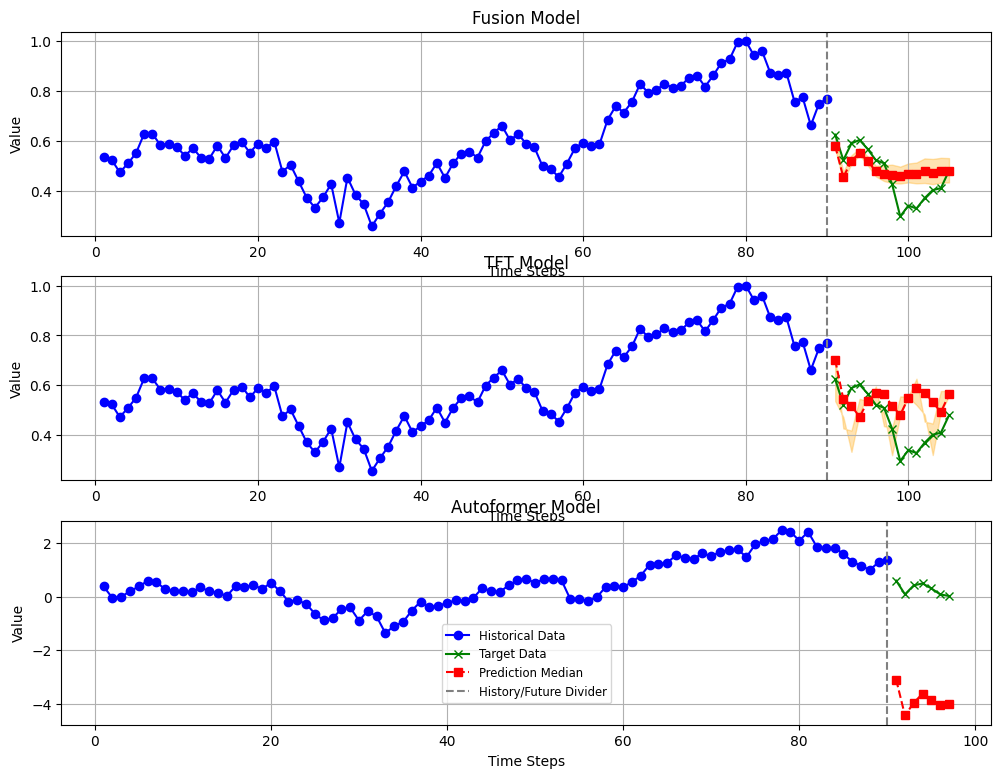

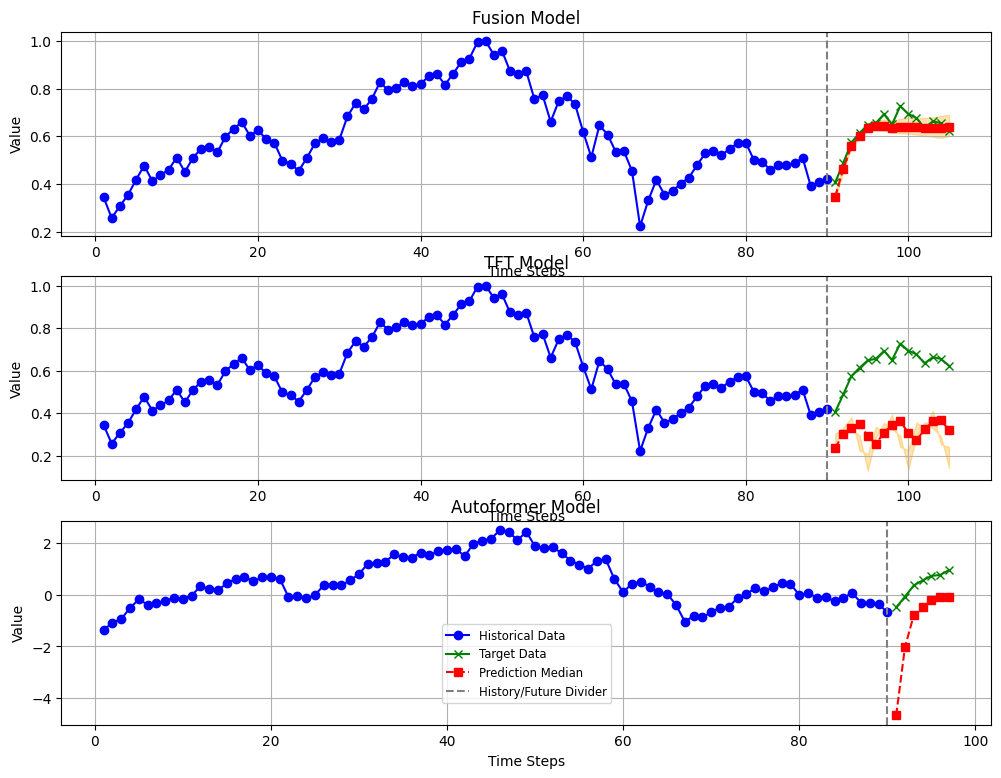

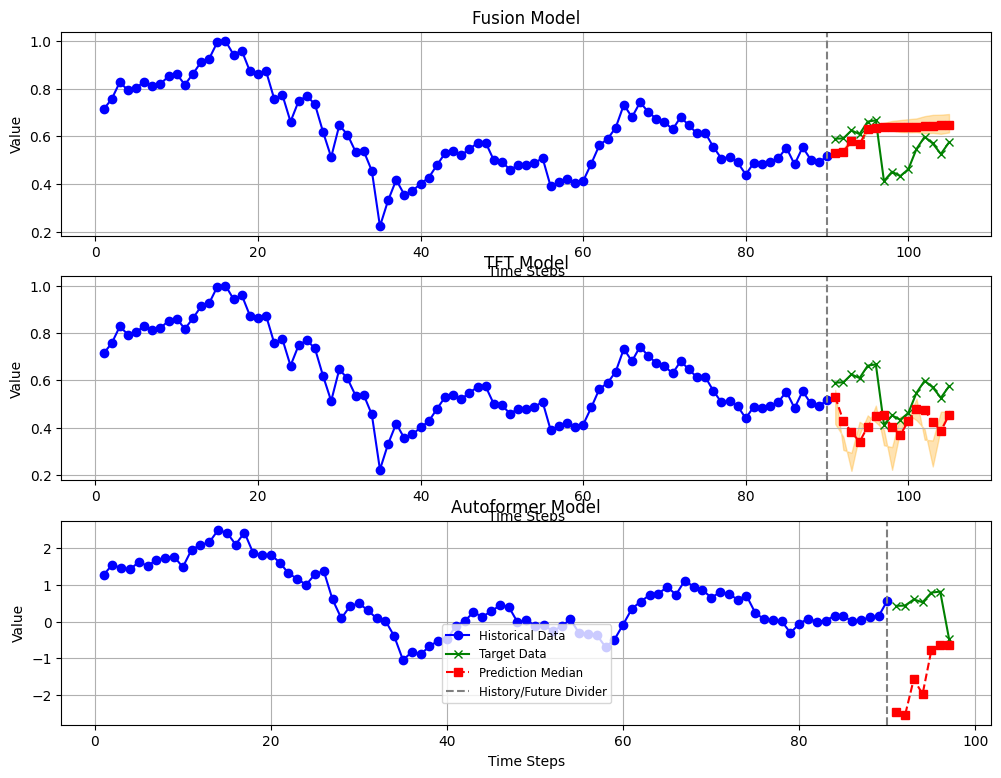

In [193]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(len(history_list)):
    plt.figure(figsize=(12, 9))
    
    history = history_list[i][0][:,0].cpu().numpy()
    target = target_list[i][0].cpu().numpy()

    predictions  = fusion_list[i][0].cpu().numpy()


    # Combine history and future indices
    history_indices = np.arange(1, len(history) + 1)
    future_indices = np.arange(len(history) + 1, len(history) + len(target) + 1)
    plt.subplot(3, 1, 1)
    # Plot history
    
    plt.plot(history_indices, history, label="Historical Data", color="blue", marker="o")

    # Plot target
    plt.plot(future_indices, target, label="Target Data", color="green", marker="x")

    plt.fill_between(
        future_indices,
        predictions[:, 0],  # Lower quantile
        predictions[:, 2],  # Upper quantile
        color="orange",
        alpha=0.3,
        label="Prediction Range (Quantiles)"
    )
    plt.plot(future_indices, predictions[:,1], color="red", linestyle="--", marker="s", label="Prediction Median")

    # Add divider, labels, and legend
    plt.axvline(x=len(history), color='gray', linestyle='--', label='History/Future Divider')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Fusion Model")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    plt.grid()

    predictions  = tft_list[i][0].cpu().numpy()

    # Combine history and future indices
    history_indices = np.arange(1, len(history) + 1)
    future_indices = np.arange(len(history) + 1, len(history) + len(target) + 1)
    plt.subplot(3, 1, 2)
    # Plot history
    
    plt.plot(history_indices, history, label="Historical Data", color="blue", marker="o")

    # Plot target
    plt.plot(future_indices, target, label="Target Data", color="green", marker="x")

    plt.fill_between(
        future_indices,
        predictions[:, 0],  # Lower quantile
        predictions[:, 2],  # Upper quantile
        color="orange",
        alpha=0.3,
        label="Prediction Range (Quantiles)"
    )
    plt.plot(future_indices, predictions[:,1], color="red", linestyle="--", marker="s", label="Prediction Median")

    # Add divider, labels, and legend
    plt.axvline(x=len(history), color='gray', linestyle='--', label='History/Future Divider')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("TFT Model")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    plt.grid()

    
    predictions  = autoformer_list[i][0].cpu().numpy()

    # Combine history and future indices
    history = autoformer_hist[i][0][:,-1].cpu().numpy()
    target = autoformer_future[i][0].cpu().numpy()
    history_indices = np.arange(1, len(history) + 1)
    future_indices = np.arange(len(history) + 1, len(history) + len(target) + 1)
    plt.subplot(3,1 , 3)
    # Plot history
    
    plt.plot(history_indices, history, label="Historical Data", color="blue", marker="o")

    # Plot target
    plt.plot(future_indices, target, label="Target Data", color="green", marker="x")

    plt.plot(future_indices, predictions, color="red", linestyle="--", marker="s", label="Prediction Median")

    # Add divider, labels, and legend
    plt.axvline(x=len(history), color='gray', linestyle='--', label='History/Future Divider')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Autoformer Model")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend(loc="center", bbox_to_anchor=(0.5, 0.3), fontsize='small')
    plt.grid()
    plt.savefig(f"result/img_{i}.png")


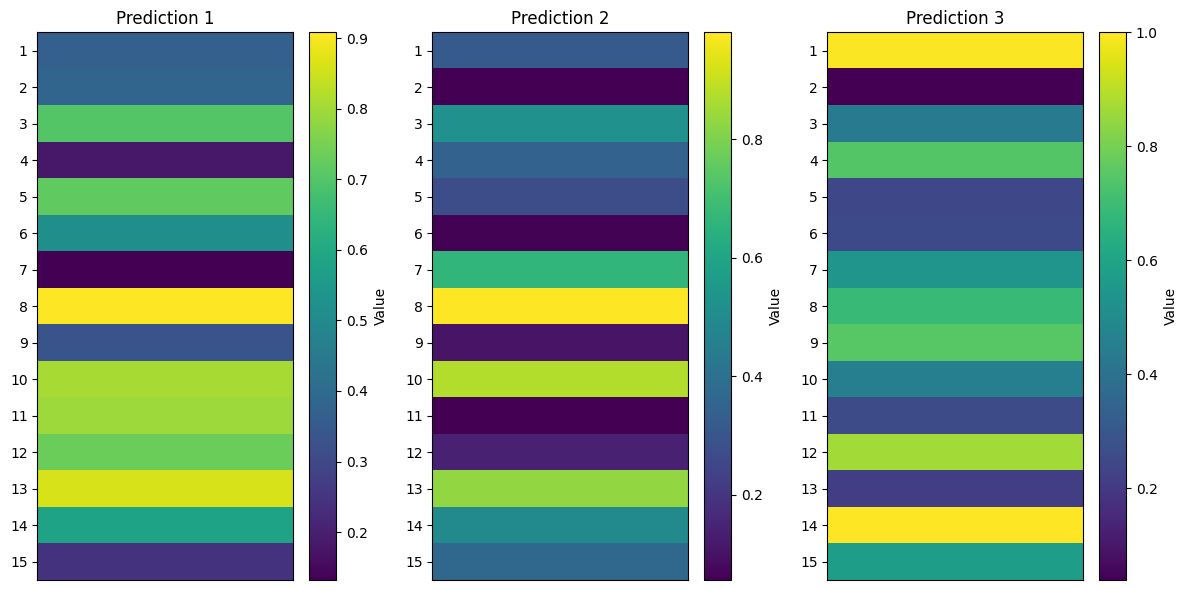

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# Sample prediction data: [15 future steps, 3 predictions]
predictions = np.random.rand(15, 3)  # Replace with your actual prediction data

# Normalize the data for better visualization (optional, based on your data)
predictions = predictions / np.max(predictions)

# Create a figure
plt.figure(figsize=(12, 6))

# Display predictions as side-by-side "images"
for i in range(predictions.shape[1]):  # Loop over 3 prediction sets
    plt.subplot(1, 3, i + 1)  # Create a subplot for each prediction
    plt.imshow(predictions[:, i].reshape(-1, 1), cmap='viridis', aspect='auto')
    plt.title(f"Prediction {i + 1}")
    plt.colorbar(label="Value")
    plt.xticks([])  # Remove x-ticks for simplicity
    plt.yticks(range(predictions.shape[0]), range(1, predictions.shape[0] + 1))  # Label time steps

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
